# Name

Yuting Kou, Yizhou Wang, Yiming Xu, Ziyi Zhou

## Content

## Method

## Toy Example

In [1]:
import matplotlib.pyplot as plt
from autograd import numpy as np

from src.Inference import Inference
from src.Subspace import Subspace
from src.model import Model
from src.util import hidecode
# hidecode()            % --------- remember to remove comments after finishing all the code. This function can simplify the code

In [2]:
data = np.load(r'.\example\data.npy')
x, y = data[:, 0], data[:, 1]

alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c) ** 2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': 'rbf',
                'activation_fn_params': 'c=0, alpha=1',
                'activation_fn': h}
# set random state to make the experiments replicable
rand_state = 127
random = np.random.RandomState(rand_state)

In [4]:
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture)
my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()
# my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w)
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w)

In [4]:
# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=P, w_hat=w)

In [5]:

my_inference.train(X=x, y=y, warm_start=True, position_init=None)

# get posterior z
n_sample = 10
post_sample = my_inference.get_posterior(n_samples=n_sample).reshape(-1, 2)
x_test = np.linspace(-8, 8, 100)
y_test = np.reshape(
    [my_nn.forward(P=P, w_hat=w, z=post_sample[i], X=x_test.reshape(1, -1)) for i in range(n_sample)],
    (n_sample, -1)) \
         + np.random.normal(0, my_nn.Sigma_Y_det ** 0.5, size=(n_sample, len(x_test)))
# because here Sigma_Y is 1-D, so determinants=its value

[0.17640523 0.04001572 0.0978738  0.22408932]
Iteration 0 lower bound -107827.94757485563; gradient mag: 59999.36099994443
[ 0.33347406 -0.43882814 -3.11498254 -3.32714795]
Iteration 200 lower bound -73300.76806017666; gradient mag: 5344.419485968306
[ 0.35893901 -0.43393584 -3.82700491 -4.11928665]
Iteration 400 lower bound -73383.86406956056; gradient mag: 5131.624334543485
[ 0.36533235 -0.45516106 -4.17456515 -4.42787924]
Iteration 600 lower bound -73518.63942600864; gradient mag: 9794.758806566451
[ 0.36991327 -0.43617999 -4.38544763 -4.73002994]
Iteration 800 lower bound -73168.11788849765; gradient mag: 1857.2062349341766


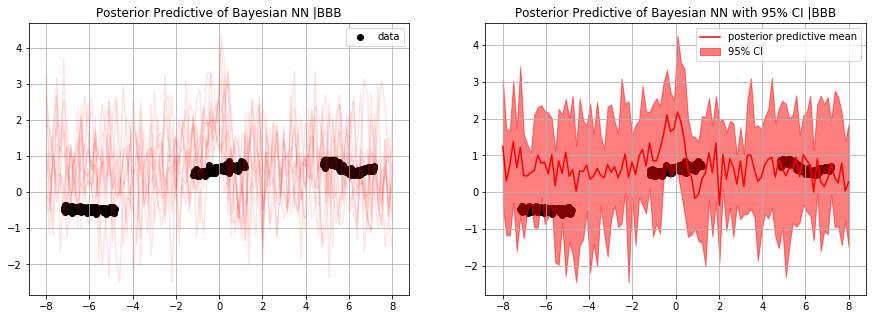

In [8]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |BBB')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test, 0.25, axis=0), np.percentile(y_test, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI |BBB')
plt.grid()
# plt.ylim(-15, 15)
plt.show()